## Data preparation for training on pregenerated patches

### Create dataset patches 256x256

In [1]:
from utils import *
from neural_network import *

ctx_dir = './ctx/cropped/normalized'
crism_dir = './normalized_evc'
output_dir = './pregenerated_patches'
os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(crism_dir):
    if file.endswith(".img"):
        crism_base_name = get_base_name(file)
        crism_path = os.path.join(crism_dir, file)
        for ctx_file in os.listdir(ctx_dir):
            if crism_base_name in ctx_file and ctx_file.endswith('.cub'):
                ctx_path = os.path.join(ctx_dir, ctx_file)
        extract_valid_patches(ctx_path, crism_path, output_dir, stride=128)

KeyboardInterrupt: 

### Plot extracted patches

C:\Users\USER\AppData\Local\Temp\ipykernel_12056\1274094051.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ctx_patch = torch.load(ctx_path)  # Shape: (1, 256, 256)
C:\

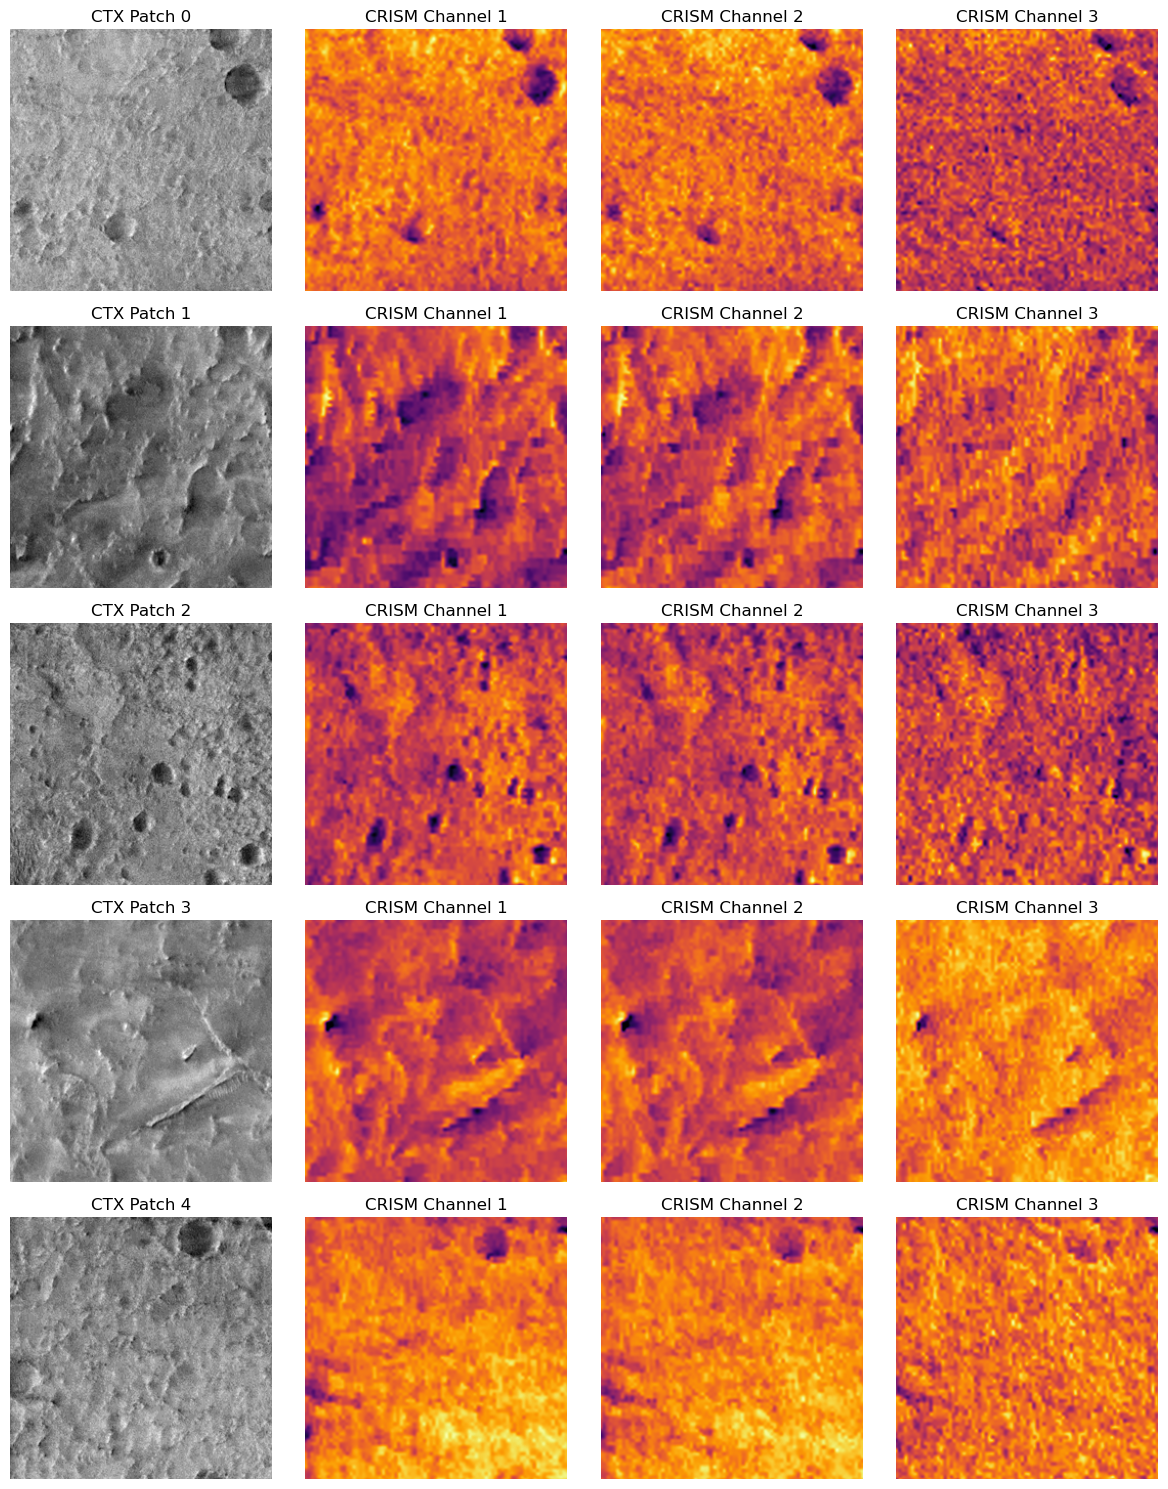

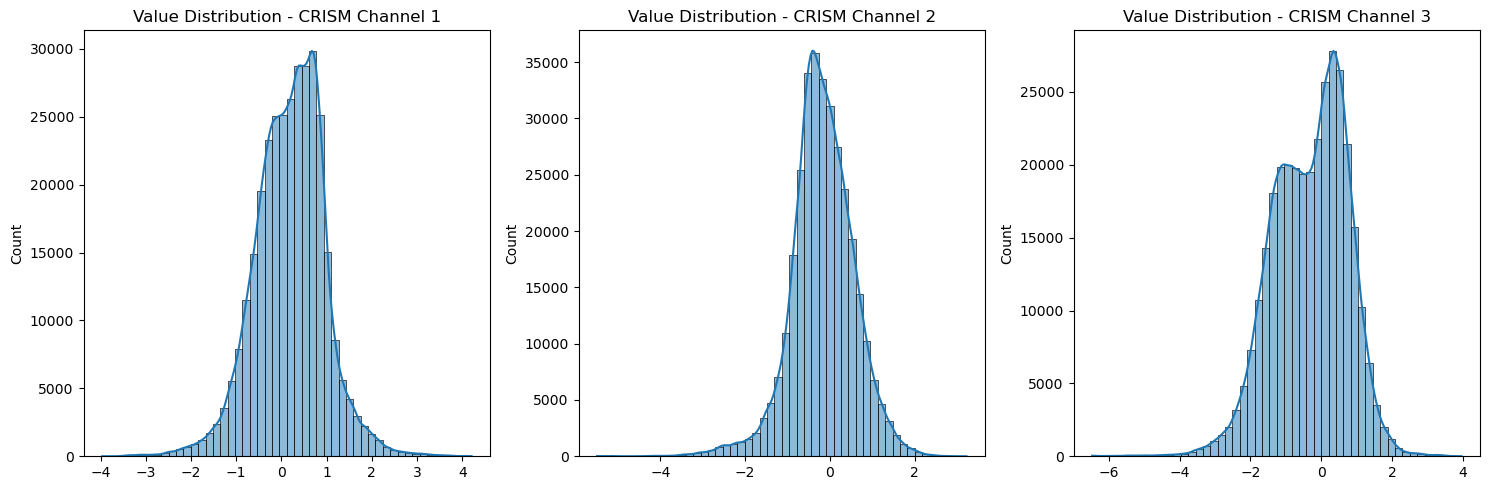

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import torch
import os

crism_dir = './pregenerated_patches/crism/train'
ctx_dir = './pregenerated_patches/ctx/train'

def visualize_patches(ctx_patches, crism_patches, num_samples=5):
    """
    Visualizes a few sample patches and their value distributions.

    Args:
        ctx_patches (list of np.ndarray): List of CTX patches.
        crism_patches (list of np.ndarray): List of CRISM patches.
        num_samples (int): Number of patches to display.
    """
    num_samples = min(num_samples, len(ctx_patches))

    fig, axes = plt.subplots(num_samples, 4, figsize=(12, 3 * num_samples))
    
    for i in range(num_samples):
        idx = random.randint(0, len(ctx_patches) - 1)
        
        ctx_patch = ctx_patches[idx]
        crism_patch = crism_patches[idx]  # (3, H, W)

        # CTX Image (Single Channel)
        axes[i, 0].imshow(ctx_patch.squeeze(0), cmap="gray")
        axes[i, 0].set_title(f"CTX Patch {i}")
        axes[i, 0].axis("off")

        # CRISM Image Channels
        for j in range(3):
            axes[i, j + 1].imshow(crism_patch[j], cmap="inferno")
            axes[i, j + 1].set_title(f"CRISM Channel {j + 1}")
            axes[i, j + 1].axis("off")

    plt.tight_layout()
    plt.show()

def plot_value_distribution(crism_patches, num_samples=5):
    """
    Plots the value distribution of CRISM patches.

    Args:
        crism_patches (list of np.ndarray): List of CRISM patches (3, H, W).
        num_samples (int): Number of patches to sample for distribution.
    """
    num_samples = min(num_samples, len(crism_patches))

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for j in range(3):  # Loop over CRISM channels
        all_values = []
        
        for i in range(num_samples):
            idx = random.randint(0, len(crism_patches) - 1)
            crism_patch = crism_patches[idx]
            all_values.extend(crism_patch[j].flatten())

        # Plot Histogram
        sns.histplot(all_values, bins=50, kde=True, ax=axes[j])
        axes[j].set_title(f"Value Distribution - CRISM Channel {j+1}")

    plt.tight_layout()
    plt.show()

# Load pregenerated patches
def load_pytorch_patches(ctx_dir, crism_dir):
    """
    Loads CTX and CRISM patches from .pt files.

    Args:
        ctx_dir (str): Directory containing CTX patches.
        crism_dir (str): Directory containing CRISM patches.

    Returns:
        tuple: (list of ctx_patches, list of crism_patches)
    """
    ctx_patches = []
    crism_patches = []

    # Get sorted file lists to match corresponding patches
    ctx_files = sorted([f for f in os.listdir(ctx_dir) if f.endswith(".pt")])
    crism_files = sorted([f for f in os.listdir(crism_dir) if f.endswith(".pt")])

    for ctx_file, crism_file in zip(ctx_files, crism_files):
        ctx_path = os.path.join(ctx_dir, ctx_file)
        crism_path = os.path.join(crism_dir, crism_file)

        # Load the patches as PyTorch tensors
        ctx_patch = torch.load(ctx_path)  # Shape: (1, 256, 256)
        crism_patch = torch.load(crism_path)  # Shape: (3, 256, 256)

        ctx_patches.append(ctx_patch)
        crism_patches.append(crism_patch)

    return ctx_patches, crism_patches


ctx_patches, crism_patches = load_pytorch_patches(ctx_dir, crism_dir)
visualize_patches(ctx_patches, crism_patches, num_samples=5)
plot_value_distribution(crism_patches, num_samples=5)


In [ ]:
crism_patches = np.array(crism_patches)
# count nan values
nan_count = np.count_nonzero(np.isnan(crism_patches))
print(f"Number of NaN values: {nan_count}")

Number of NaN values: 0


In [ ]:
ctx_path = './ctx/cropped/FRT0001ECBA_07_IFEVCJ_MTR3_G13_023102_1986_XN_18N282W.cub'
crism_path = './normalized_evc/FRT0001ECBA_07_IFEVCJ_MTR3.rp.global.local.img'

with rasterio.open(ctx_path) as ctx_ds, rasterio.open(crism_path) as crism_ds:
        ctx_data = ctx_ds.read().astype(np.float32)
        crism_data = crism_ds.read().astype(np.float32)

        print(ctx_data.shape, crism_data.shape)

(1, 2447, 2467) (3, 2447, 2467)


### Split dataset

In [ ]:
from neural_network import *

ctx_dir = './pregenerated_patches/ctx/all_files'
crism_dir = './pregenerated_patches/crism/all_files'
output_dir = './pregenerated_patches'

split_into_train_test_val(ctx_dir, crism_dir, output_dir)

d:\USER\Studies_in_THD\thesis\hyperspectral_mars\neural_network.py:272: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.save(torch.load(ctx_file), os.path.join(ctx_split

Saved train split to ./pregenerated_patches
Saved val split to ./pregenerated_patches
Saved test split to ./pregenerated_patches


### Split dataset so that single pair patches included into single split directory

In [ ]:
from collections import defaultdict
import shutil
import os
import numpy as np

def split_into_tvt_by_pairs(base_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Splits patches into train, val, and test sets, ensuring all patches from the same 
    original image stay in the same split.

    Args:
        base_dir (str): Base directory containing ctx and crism folders.
        output_base (str): Base directory where train/val/test folders will be created.
        train_ratio (float): Percentage of data to be used for training.
        val_ratio (float): Percentage of data to be used for validation.
        test_ratio (float): Percentage of data to be used for testing.

    Returns:
        None
    """
     # Path configuration
    modalities = ('ctx', 'crism')
    all_dirs = {mod: os.path.join(base_dir, mod, "all_files") for mod in modalities}
    split_names = ('train', 'val', 'test')

    ctx_output_dirs = {
        "train": os.path.join(base_dir, "ctx", "train"),
        "val": os.path.join(base_dir, "ctx", "val"),
        "test": os.path.join(base_dir, "ctx", "test"),
    }
    crism_output_dirs = {
        "train": os.path.join(base_dir, "crism", "train"),
        "val": os.path.join(base_dir, "crism", "val"),
        "test": os.path.join(base_dir, "crism", "test"),
    }

    # Create output directories
    for path in list(ctx_output_dirs.values()) + list(crism_output_dirs.values()):
        os.makedirs(path, exist_ok=True)
    
    # Create output directories
    for split in split_names:
        for mod in modalities:
            os.makedirs(os.path.join(base_dir, mod, split), exist_ok=True)

    # Group patches by image pair base name
    patch_groups = defaultdict(list)
    for filename in os.listdir(all_dirs["ctx"]):
        if filename.endswith(".pt"):
            base_name = "_".join(filename.split("_")[1:7])  # Extract base pair identifier
            patch_groups[base_name].append(filename)

    # Split the groups into train, val, and test sets
    all_pairs = list(patch_groups.keys())
    np.random.shuffle(all_pairs)
    num_pairs = len(all_pairs)

    train_end = int(num_pairs * train_ratio)
    val_end = int(num_pairs * (train_ratio + val_ratio))

    train_pairs_base = all_pairs[:train_end]
    val_pairs_base = all_pairs[train_end:val_end]
    test_pairs_base = all_pairs[val_end:]

    train_pairs_ctx = filter_strings_by_substrings(os.listdir(all_dirs["ctx"]), train_pairs_base)
    val_pairs_ctx = filter_strings_by_substrings(os.listdir(all_dirs["ctx"]), val_pairs_base)
    test_pairs_ctx = filter_strings_by_substrings(os.listdir(all_dirs["ctx"]), test_pairs_base)

    train_pairs_crism = filter_strings_by_substrings(os.listdir(all_dirs["crism"]), train_pairs_base)
    val_pairs_crism = filter_strings_by_substrings(os.listdir(all_dirs["crism"]), val_pairs_base)
    test_pairs_crism = filter_strings_by_substrings(os.listdir(all_dirs["crism"]), test_pairs_base)

    # Move patches to corresponding directories
    move_patches(base_dir, train_pairs_ctx, "ctx", "train")
    move_patches(base_dir, val_pairs_ctx, "ctx", "val")
    move_patches(base_dir, test_pairs_ctx, "ctx", "test")
    move_patches(base_dir, train_pairs_crism, "crism", "train")
    move_patches(base_dir, val_pairs_crism, "crism", "val")
    move_patches(base_dir, test_pairs_crism, "crism", "test")

    print(f"Saved train, val, and test splits to {base_dir}")

def move_patches(base_dir, file_names, mod, split):
    """
    Moves patches from one directory to another.

    Args:
        base_dir (str): Base directory containing patches.
        file_names (list of str): List of patch file names.
        mod (str): Modality of patches (ctx or crism).
        split (str): Split to move patches to (train, val, or test).

    Returns:
        None
    """
    for file in file_names:
        src_path = os.path.join(base_dir, mod, "all_files", file)
        dst_path = os.path.join(base_dir, mod, split, file)
        shutil.move(src_path, dst_path)

def filter_strings_by_substrings(main_list, substrings):
    """Return elements from main_list that contain any substring from substrings."""
    return [s for s in main_list if any(sub in s for sub in substrings)]


base_dir = './pregenerated_patches'
split_into_tvt_by_pairs(base_dir)

Saved train, val, and test splits to ./pregenerated_patches


## Training process

### Loading data

In [1]:
from neural_network import *
from torch.utils.data import DataLoader
from utils import *
from torch.utils.tensorboard import SummaryWriter

ctx_train_dir = "./ctx/cropped/cropped_to_valid"
crism_train_dir = "./normalized_evc"
ctx_test_dir = "./ctx/cropped/cropped_to_valid/test"
crism_test_dir = "./normalized_evc/test"
ctx_val_dir = "./ctx/cropped/cropped_to_valid/val"
crism_val_dir = "./normalized_evc/val"
output_dir = "./results"
os.makedirs(output_dir, exist_ok=True)

batch_size = 16
patch_size = 256
num_epochs = 1020
learning_rate = 2e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ctx, train_crism = get_files_from_dir(ctx_train_dir, ".cub"), get_files_from_dir(crism_train_dir, ".img")
test_ctx, test_crism = get_files_from_dir(ctx_test_dir, ".cub"), get_files_from_dir(crism_test_dir, ".img")
val_ctx, val_crism = get_files_from_dir(ctx_val_dir, ".cub"), get_files_from_dir(crism_val_dir, ".img")

train_dataset = CTXCRISMDataset(train_ctx, train_crism, transform=get_transforms(patch_size))
val_dataset = CTXCRISMDataset(val_ctx, val_crism, transform=get_val_transforms(patch_size))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

d:\Software\Python\anaconda\envs\nn\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
d:\Software\Python\anaconda\envs\nn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Software\Python\anaconda\envs\nn\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS

### Trying out the model

In [2]:
model = get_model()
criterion = torch.nn.MSELoss()
# criterion = MaskedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer = SummaryWriter()
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, writer)
writer.close()

# Save the trained model
torch.save(trained_model.state_dict(), os.path.join(output_dir, "unet_14_expanded.pth"))

# Evaluate on test set
test_dataset = CTXCRISMDataset(test_ctx, test_crism, transform=get_val_augmentations(patch_size))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validate_model(trained_model, test_loader, criterion, 1, device, writer)

d:\Software\Python\anaconda\envs\nn\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/1020], Train Loss: 1.9228
Validation Loss: 2.2352
Epoch [2/1020], Train Loss: 1.9986
Validation Loss: 1.2681
Epoch [3/1020], Train Loss: 2.4253
Validation Loss: 1.5536
Epoch [4/1020], Train Loss: 2.2093
Validation Loss: 1.6949
Epoch [5/1020], Train Loss: 2.6657
Validation Loss: 1.7918
Epoch [6/1020], Train Loss: 1.5963
Validation Loss: 0.8678
Epoch [7/1020], Train Loss: 1.5047
Validation Loss: 1.3237
Epoch [8/1020], Train Loss: 1.1227
Validation Loss: 1.0612
Epoch [9/1020], Train Loss: 1.5076
Validation Loss: 1.1608
Epoch [10/1020], Train Loss: 1.3963
Validation Loss: 0.6106
Epoch [11/1020], Train Loss: 1.3795
Validation Loss: 0.5920
Epoch [12/1020], Train Loss: 1.0462
Validation Loss: 1.1104
Epoch [13/1020], Train Loss: 1.5659
Validation Loss: 1.2162
Epoch [14/1020], Train Loss: 1.0713
Validation Loss: 1.1995
Epoch [15/1020], Train Loss: 1.3962
Validation Loss: 1.2795
Epoch [16/1020], Train Loss: 1.2538
Validation Loss: 1.0338
Epoch [17/1020], Train Loss: 1.2469
Validation Lo

KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'

## Training model on pregenerated patches

### Loading data

In [ ]:
from neural_network import get_model
from prepatched_nn import *
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from utils import *

ctx_train_dir = "./pregenerated_patches/ctx/train"
crism_train_dir = "./pregenerated_patches/crism/train"
ctx_test_dir = "./pregenerated_patches/ctx/test"
crism_test_dir = "./pregenerated_patches/crism/test"
ctx_val_dir = "./pregenerated_patches/ctx/val"
crism_val_dir = "./pregenerated_patches/crism/val"
output_dir = "./results"
os.makedirs(output_dir, exist_ok=True)

batch_size = 8
patch_size = 256
num_epochs = 360
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ctx, train_crism = get_files_from_dir(ctx_train_dir, ".pt"), get_files_from_dir(crism_train_dir, ".pt")
test_ctx, test_crism = get_files_from_dir(ctx_test_dir, ".pt"), get_files_from_dir(crism_test_dir, ".pt")
val_ctx, val_crism = get_files_from_dir(ctx_val_dir, ".pt"), get_files_from_dir(crism_val_dir, ".pt")

train_dataset = PatchedDataset(train_ctx, train_crism)
val_dataset = PatchedDataset(val_ctx, val_crism)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

d:\Software\Python\anaconda\envs\nn\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
d:\Software\Python\anaconda\envs\nn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Software\Python\anaconda\envs\nn\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS

### Trying out the model

In [ ]:
model = get_model()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer = SummaryWriter()

trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, writer)

writer.close()

# Save the trained model
torch.save(trained_model.state_dict(), os.path.join(output_dir, "unet_prepatched_4.pth"))

# Evaluate on test set
test_dataset = PatchedDataset(test_ctx, test_crism)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validate_model(trained_model, test_loader, criterion, device)

d:\USER\Studies_in_THD\thesis\hyperspectral_mars\neural_network.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ctx_data = torch.load(ctx_path)
d:\USER\Studies_in_THD\

Epoch [1/360], Train Loss: 0.6433
Validation Loss: 0.8054
Epoch [2/360], Train Loss: 0.5361
Validation Loss: 0.8296
Epoch [3/360], Train Loss: 0.5172
Validation Loss: 0.7152
Epoch [4/360], Train Loss: 0.4703
Validation Loss: 0.7851
Epoch [5/360], Train Loss: 0.4375
Validation Loss: 0.7543
Epoch [6/360], Train Loss: 0.4081
Validation Loss: 0.7446
Epoch [7/360], Train Loss: 0.3938
Validation Loss: 0.6949
Epoch [8/360], Train Loss: 0.3811
Validation Loss: 0.6569
Epoch [9/360], Train Loss: 0.3446
Validation Loss: 0.6745
Epoch [10/360], Train Loss: 0.3679
Validation Loss: 0.6611
Epoch [11/360], Train Loss: 0.3372
Validation Loss: 0.6826
Epoch [12/360], Train Loss: 0.3374
Validation Loss: 0.6840
Epoch [13/360], Train Loss: 0.3306
Validation Loss: 0.6571
Epoch [14/360], Train Loss: 0.3251
Validation Loss: 0.6872
Epoch [15/360], Train Loss: 0.3052
Validation Loss: 0.7305
Epoch [16/360], Train Loss: 0.3044
Validation Loss: 0.6690
Epoch [17/360], Train Loss: 0.3003
Validation Loss: 0.6797
Epoch 

TypeError: validate_model() missing 2 required positional arguments: 'epoch' and 'writer'

### Compare prediction with target

C:\Users\USER\AppData\Local\Temp\ipykernel_43256\3433491133.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./results/unet_evc_model_13

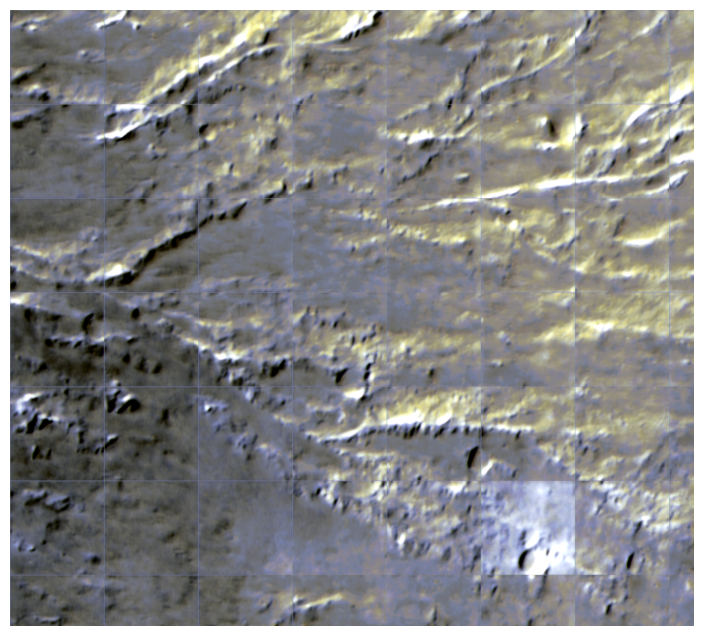

In [4]:
import torch
from neural_network import *
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model()

model.load_state_dict(torch.load("./results/unet_evc_model_13_expanded.pth", map_location=device))
model.to(device)
model.eval()

ctx_path = 'ctx/cropped/cropped_to_valid/FRT0000A98D_07_IFEVCJ_MTR3_P18_008193_1536_XN_26S034W.cub'
with rasterio.open(ctx_path) as ctx_ds:
    ctx_image = ctx_ds.read().astype(np.float32)

# ctx_path = './pregenerated_patches/ctx/test/ctx_FRT0001ECBA_07_IFEVCJ_MTR3_G13_023102_1986_XN_18N282W_171.pt'
# ctx_image = torch.load(ctx_path)

patch_size = 256
predicted_crism = evaluate_model(model, ctx_image[0], patch_size, device)

display_ready_image = create_np_image(predicted_crism, sigma_stretch=True).transpose(1, 2, 0)

plt.figure(figsize=(10, 8)) 
plt.imshow(display_ready_image)
plt.axis('off')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_28440\406708743.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('./pregenerated_patches/crism/test/crism_FRT

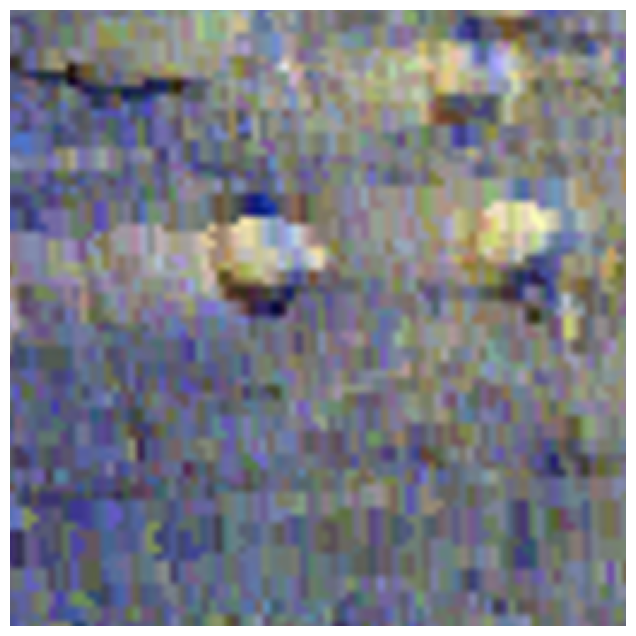

In [ ]:
import matplotlib.pyplot as plt

data = torch.load('./pregenerated_patches/crism/test/crism_FRT0001ECBA_07_IFEVCJ_MTR3_G13_023102_1986_XN_18N282W_171.pt')

rgb_image = create_np_image(data).transpose(1, 2, 0)

# Plot the RGB image
plt.figure(figsize=(10, 8)) 
plt.imshow(rgb_image)
plt.axis('off')  # Hide axis ticks
plt.show()

# CaSSIS CRISM training

### Loading data

In [1]:
from neural_network_phase_2 import *
from torch.utils.data import DataLoader
from utils import *
from torch.utils.tensorboard import SummaryWriter

cassis_train_dir = 'G:/thesis_data_arch/jezero/cassis/dataset/transfered/3_normalized/train'
crism_train_dir = 'G:/thesis_data_arch/jezero/evcs/phase_2/transfered/5_normalized/train'
cassis_test_dir = 'G:/thesis_data_arch/jezero/cassis/dataset/transfered/3_normalized/test'
crism_test_dir = 'G:/thesis_data_arch/jezero/evcs/phase_2/transfered/5_normalized/test'
cassis_val_dir = 'G:/thesis_data_arch/jezero/cassis/dataset/transfered/3_normalized/val'
crism_val_dir = 'G:/thesis_data_arch/jezero/evcs/phase_2/transfered/5_normalized/val'
output_dir = './results/phase_2'
os.makedirs(output_dir, exist_ok=True)

batch_size = 16
patch_size = 256
num_epochs = 360
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_cassis, train_crism = get_files_from_dir(cassis_train_dir, ".cub"), get_files_from_dir(crism_train_dir, ".tif")
test_cassis, test_crism = get_files_from_dir(cassis_test_dir, ".cub"), get_files_from_dir(crism_test_dir, ".tif")
val_cassis, val_crism = get_files_from_dir(cassis_val_dir, ".cub"), get_files_from_dir(crism_val_dir, ".tif")

train_dataset = CaSSISCRISMDataset(train_cassis, train_crism, transform=get_transforms(patch_size))
val_dataset = CaSSISCRISMDataset(val_cassis, val_crism, transform=get_val_transforms(patch_size))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

g:\Software\Miniconda\miniconda3\envs\nnmamba\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Train

In [3]:
model = get_crism_cassis_model()
criterion = MaskedMSELoss(third_channel_factor=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer = SummaryWriter()
trained_model = train_masked_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, writer)
writer.close()

# Save the trained model
torch.save(trained_model.state_dict(), os.path.join(output_dir, "unet_cassis_crism_mse_0.5_blue.pth"))

# Evaluate on test set
test_dataset = CaSSISCRISMDataset(test_cassis, test_crism, transform=get_val_augmentations(patch_size))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validate_masked_model(trained_model, test_loader, criterion, device)

Rejected patch from index 5: valid ratio = 0.15
Rejected patch from index 5: valid ratio = 0.11
Rejected patch from index 2: valid ratio = 0.16
Rejected patch from index 5: valid ratio = 0.16
Rejected patch from index 1: valid ratio = 0.71
Rejected patch from index 3: valid ratio = 0.12
Rejected patch from index 1: valid ratio = 0.14
Rejected patch from index 1: valid ratio = 0.68
Rejected patch from index 0: valid ratio = 0.12
Rejected patch from index 1: valid ratio = 0.17
Epoch [1/360], Train Loss: 13.6631
Rejected patch from index 0: valid ratio = 0.97
Rejected patch from index 0: valid ratio = 0.13
Rejected patch from index 2: valid ratio = 0.13
Rejected patch from index 3: valid ratio = 0.63
Rejected patch from index 1: valid ratio = 0.15
Rejected patch from index 2: valid ratio = 0.67
Rejected patch from index 2: valid ratio = 0.18
Epoch [2/360], Train Loss: 18.7224
Rejected patch from index 0: valid ratio = 0.00
Rejected patch from index 0: valid ratio = 0.00
Rejected patch fro

g:\hyperspectral_mars\utils.py:340: RuntimeWarning: invalid value encountered in divide
  band_norm = (band - band_min) / (band_max - band_min) * 255
g:\hyperspectral_mars\utils.py:341: RuntimeWarning: invalid value encountered in cast
  return band_norm.astype(np.uint8)


Epoch [161/360], Train Loss: 21.1157
Rejected patch from index 3: valid ratio = 0.70
Rejected patch from index 5: valid ratio = 0.29
Rejected patch from index 2: valid ratio = 0.11
Rejected patch from index 2: valid ratio = 0.10
Epoch [162/360], Train Loss: 6.7249
Rejected patch from index 1: valid ratio = 0.15
Rejected patch from index 0: valid ratio = 0.70
Rejected patch from index 2: valid ratio = 0.19
Rejected patch from index 2: valid ratio = 0.16
Rejected patch from index 5: valid ratio = 0.69
Rejected patch from index 2: valid ratio = 0.12
Rejected patch from index 2: valid ratio = 0.46
Rejected patch from index 5: valid ratio = 0.12
Rejected patch from index 3: valid ratio = 0.12
Rejected patch from index 3: valid ratio = 0.16
Rejected patch from index 4: valid ratio = 0.09
Rejected patch from index 0: valid ratio = 0.09
Epoch [163/360], Train Loss: 26.2506
Rejected patch from index 4: valid ratio = 0.14
Rejected patch from index 2: valid ratio = 0.11
Rejected patch from index 

NameError: name 'get_val_augmentations' is not defined